# Script de python sencillo para histogramas basicos 

#### Antes de empezar: una herramienta útil para descargar datos de EAGLE desde Python, es el paquete eagleSQLtools.

#### Repositorio del paquete: https://github.com/kyleaoman/eagleSqlTools

#### Para instalarlo, en una terminal correr el siguiente comando:

#### pip install eaglesqltools

#### Importar paquetes necesarios. Agregar paquete si hace falta

In [2]:
import matplotlib.pyplot as plt
import eagleSqlTools as sql
import numpy as np
from astropy.io import ascii
from astropy.table import Table

#### Simulación a usar

In [3]:
simu='RefL0100N1504'

#### Snapnum a usar

In [3]:
snap=28

#### Carpetas y archivos de tablas de datos para lectura, si es que hay archivos de datos

In [5]:
data_folder='/home/ramiro/Facultad/Tesis/Python/prueba_galaxias_RefL0100N1504/'
data_snap_28='prueba_galaxias_'+simu+'_snap_'+str(snap)+'.dat'
data_snap_28_path=data_folder+data_snap_28
table_snap_28=ascii.read(data_snap_28_path,comment='#',format='csv',fast_reader='True')

#### O sino, podemos descargar datos mediante eagleSQLtools

In [4]:
# Usuario y contraseña para conectarse a EAGLE DataBase (USAR LOS DATOS PROPIOS!!)
usr='cht015'
pwd='BH457tfj'

# Conectarse a la base de datos
con = sql.connect(usr, password=pwd)

# Query en SQL
query = "SELECT \
         sub.GalaxyID,sub.Redshift, sub.SnapNum, sub.SubGroupNumber, \
         sub.CentreOfPotential_x,sub.CentreOfPotential_y,sub.CentreOfPotential_z, \
         sub.Stars_Mass, sub.SF_Mass, sub.NSF_Mass, sub.MassType_DM, sub.MassType_BH, \
         sub.HalfMassRad_Star,sub.HalfMassRad_Gas, HalfMassRad_DM, \
         sub.Stars_Hydrogen,sub.Stars_Oxygen,sub.Stars_Metallicity, \
         sub.SF_Hydrogen,sub.SF_Oxygen,sub.SF_Metallicity, \
         sub.NSF_Hydrogen,sub.NSF_Oxygen,sub.NSF_Metallicity, \
         sub.StarFormationRate,sub.InitialMassWeightedStellarAge \
         FROM "+simu+"_subhalo as sub \
         WHERE sub.SnapNum="+str(snap)+" and sub.Stars_Mass>=1e9"

# Execute query 
exquery = sql.execute_query(con, query)

# List of column names of downloaded data
colnames=(exquery.view(np.recarray).dtype.names)


# Dictionary of identifiers
table_snap_28={}
for name in colnames:
    table_snap_28[name]=exquery[name]
    

In [5]:
# Si es necesario, podemos guardar los datos en un archivo ascii

# Abrir el archivo donde se guardarán los datos
outf=open('prueba_galaxias_'+simu+'_snap_'+str(snap)+'.dat','w')

# Transformar el diccionario a una tabla ascii
data_ascii=Table(table_snap_28)

# Escribir los datos al archivo
data_ascii.write(outf,format='csv')

# Cerrar el archivo
outf.close()

#### Definir variables nuevas, si es necesario

In [5]:
table_snap_28['SF_frac']=table_snap_28['SF_Mass']/(table_snap_28['SF_Mass']+table_snap_28['Stars_Mass'])
table_snap_28['sSFR']=table_snap_28['StarFormationRate']/table_snap_28['Stars_Mass']

#### Mascara para seleccionar galaxias con stellarmass mayor que 1e9 Msun

In [11]:
mask_stellarmass=(table_snap_28['Stars_Mass']>=1e10)

#### Variable de interes

In [12]:
var=np.log10(table_snap_28['Stars_Mass'][mask_stellarmass])

###  Histograma bien basico

In [13]:
#help(plt.subplots)

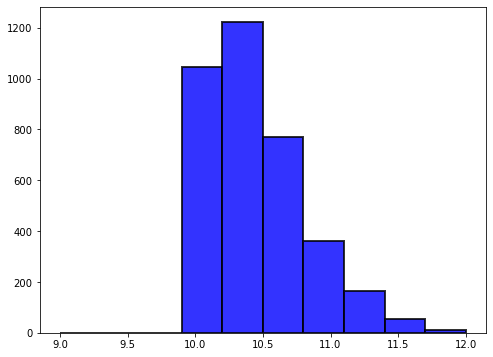

In [14]:
# Definimos un objeto figura con un objeto axis
fig,ax=plt.subplots(figsize=(8,6))
ax.hist(var,bins=10,range=(9,12),histtype='bar',label='z=0',linestyle='-',
        color='b',linewidth=2,alpha=0.8,edgecolor='k')
# plt.savefig('grafico1.png')
plt.show()

###  Histograma pesado y "tuneado" 

#### Peso (fracción de galaxias)

In [11]:
weights = np.ones_like(var)/float(len(var))

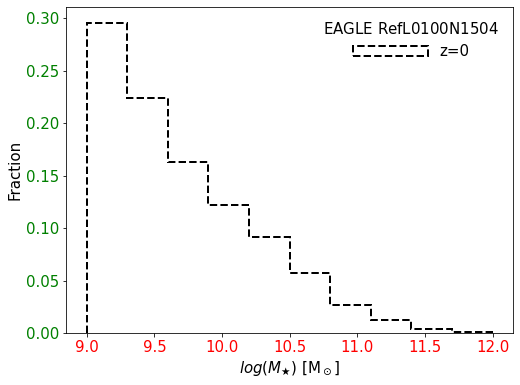

In [12]:
fig,ax=plt.subplots(figsize=(8,6))
# Etiquetas de los ejes
ax.set_xlabel(r'$log(M_\bigstar) \ [\rm{M}_\odot]$', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)

# Caracteristicas de los ticks
ax.tick_params(axis='x',labelsize=15,labelcolor='r')
ax.tick_params(axis='y',labelsize=15,labelcolor='g')

# Grafico
ax.hist(var,bins=10,range=(9,12),histtype='step',label='z=0',linestyle='--',
        color='k',linewidth=2,alpha=1,weights=weights)
#plt.tight_layout() 
leg=ax.legend(loc='upper right',fontsize=15,edgecolor='w',handlelength=5)
leg.set_title(r'$\rm{EAGLE\ RefL0100N1504}$',prop={'size':15})
plt.show()

### Histograma de dos poblaciones, pesado y "tuneado"

#### Variable auxiliar para separar poblaciones

In [13]:
var_aux=table_snap_28['SF_frac'][mask_stellarmass]

#### Población 1: galaxias con var_aux menor que 0.2

In [14]:
mask1=(var_aux<=0.2)
var1=var[mask1]
weights1=np.ones_like(var1)/float(len(var1))

#### Población 2: galaxias con var_aux mayor o igual que 0.2

In [15]:
mask2=(var_aux>0.2)
var2=var[mask2]
weights2=np.ones_like(var2)/float(len(var2))

#### Gráfico

(0.0, 0.6)

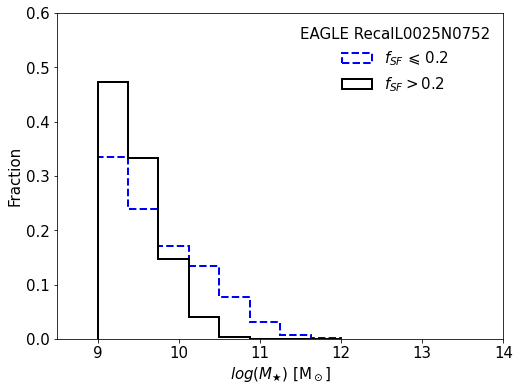

In [20]:
fig,ax=plt.subplots(figsize=(8,6))

ax.hist(var1,bins=8,histtype='step',range=(9,12),label=r'$f_{SF}\ \leqslant \ 0.2$',
        linestyle='--',color='b',linewidth=2,weights=weights1)
ax.hist(var2,bins=8,histtype='step',range=(9,12),label=r'$f_{SF}>0.2$',
        linestyle='-',color='k',linewidth=2,weights=weights2)

ax.set_xlabel(r'$log(M_\bigstar) \ [\rm{M}_\odot]$', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
ax.tick_params(axis='both',labelsize=15)
leg=ax.legend(loc='upper right',edgecolor='w',fontsize=15)
leg.set_title('EAGLE RecalL0025N0752', prop = {'size':15})

xmin,xmax=8.5,14
ax.set_xlim(xmin,xmax)

ymin,ymax=0,0.6
ax.set_ylim(ymin,ymax)
#plt.savefig('grafico.png')

### Histograma de poblaciones a distintos redshifts, pesado y "tuneado"

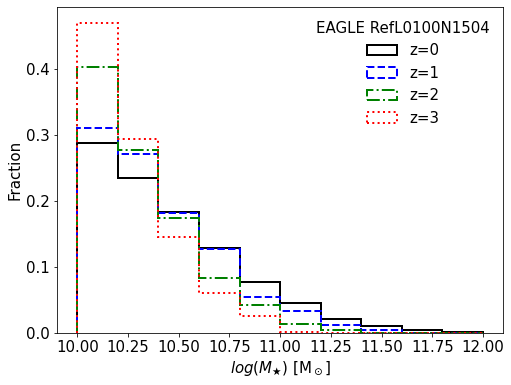

In [8]:
# En mi caso, tengo cuatro archivos ascii con datos de los snaps 28, 19, 15 y 12 
# (corespondiente a redshifts 0, 1, 2 y 3). Armo un loop para leer y hacer histos de cada archivo.
# Editar los nombres de archivos y carpetas si es necesario.

fig,ax=plt.subplots(figsize=(8,6))
snap_list=[28,19,15,12]
redshift_list=[0,1,2,3]

# Esto es para "tunear" los histogramas
color=['k','b','g','r']    # colores para cada z
line=['-','--','-.',':']   # tipo de linea para cada z

for snap,redshift,lc,ls in zip(snap_list,redshift_list,color,line):   
    data_file='prueba_galaxias_'+simu+'_snap_'+str(snap)+'.dat'
    data_path=data_folder+data_file
    table=ascii.read(data_path,comment='#',format='fast_csv') 

    mask_stellarmass=(table['Stars_Mass']>=1e19)     #Mascara para seleccionar masas adecuadas
    var=np.log10(table['Stars_Mass'][mask_stellarmass])    # Variable a usar. 
    
    weights=np.ones_like(var)/float(len(var))

    ax.hist(var,bins=10,range=(10,12),histtype='step',label='z='+str(redshift),
            linestyle=ls,color=lc,linewidth=2,weights=weights)

ax.set_xlabel(r'$log(M_\bigstar) \ [\rm{M}_\odot]$', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
ax.tick_params(axis='both',labelsize=15)

leg=plt.legend(loc='upper right',edgecolor='w',fontsize=15)
leg.set_title('EAGLE RefL0100N1504', prop = {'size':15})



## Felicidades!! Ya aprendimos a hacer histogramas sencillos